In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

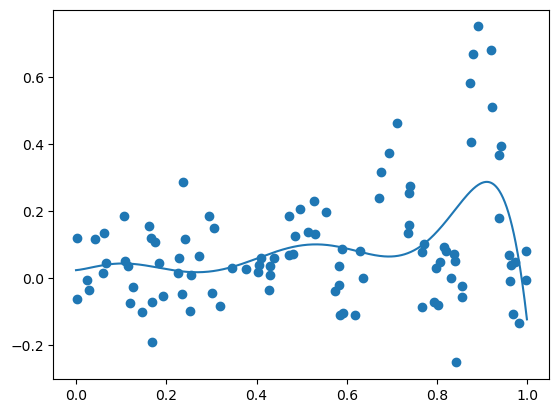

>x=0.919, f()=0.284555, actual=0.643
>x=0.913, f()=0.313078, actual=0.901
>x=0.912, f()=0.353421, actual=0.689
>x=0.128, f()=0.046096, actual=0.046
>x=0.095, f()=0.047585, actual=-0.030
>x=0.913, f()=0.374756, actual=0.571
>x=0.913, f()=0.386581, actual=0.712
>x=0.562, f()=0.100570, actual=-0.074
>x=0.914, f()=0.404840, actual=0.570
>x=0.566, f()=0.089804, actual=-0.067
>x=0.315, f()=0.019419, actual=0.136
>x=0.690, f()=0.024081, actual=0.410
>x=0.605, f()=0.074240, actual=0.010
>x=0.990, f()=-0.044179, actual=-0.057
>x=0.277, f()=0.019411, actual=0.057
>x=0.597, f()=0.074638, actual=0.096
>x=0.913, f()=0.408717, actual=0.895
>x=0.663, f()=0.041511, actual=0.245
>x=0.321, f()=0.024011, actual=0.152
>x=0.261, f()=0.025612, actual=-0.067
>x=0.807, f()=0.194050, actual=-0.012
>x=0.296, f()=0.020747, actual=0.110
>x=0.886, f()=0.400207, actual=0.782
>x=0.913, f()=0.445495, actual=0.833
>x=0.969, f()=0.229078, actual=-0.103
>x=0.273, f()=0.022329, actual=0.212
>x=0.912, f()=0.455523, actual

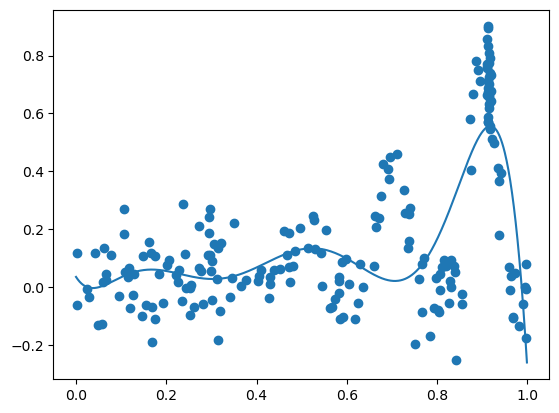

Best Result: x=0.913, y=0.901


In [2]:
# multi-modal problem with 5 peaks
# https://machinelearningmastery.com/what-is-bayesian-optimization/

# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
 
# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise
 
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)
 
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs
 
# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]
 
# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()
 
# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)
 
# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

In [31]:
# Drop wave function using method 1 (from scratch)

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

def objective(x1,x2,noise=0):
    noise = normal(loc=0, scale=noise)
    return -(1+np.cos(12*np.sqrt(x1**2+x2**2)))/(0.5*(x1**2+x2**2)+2) + noise

X1=np.asarray(np.arange(-5.12,5.12,0.01))
X1=X1.reshape(len(X1),1)
X2=np.asarray(np.arange(-5.12,5.12,0.01))
X2=X2.reshape(len(X2),1)
y =np.asarray([objective(x1,x2) for x1 in X1 for x2 in X2])

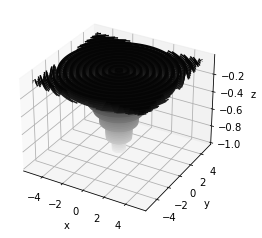

In [32]:
# learning how to plot 3-d
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(X1, X2)
Z =objective(X,Y)
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');

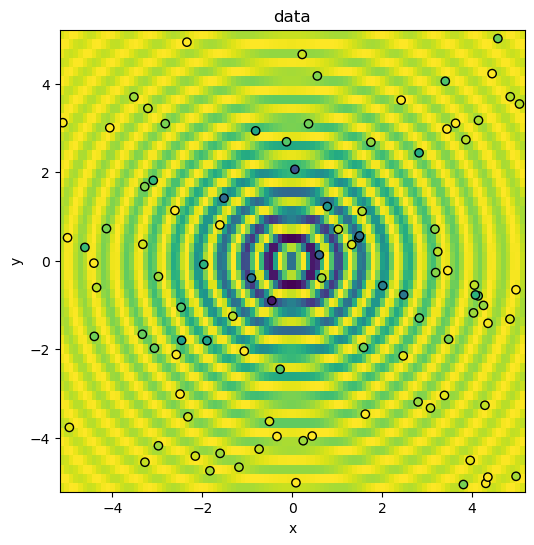

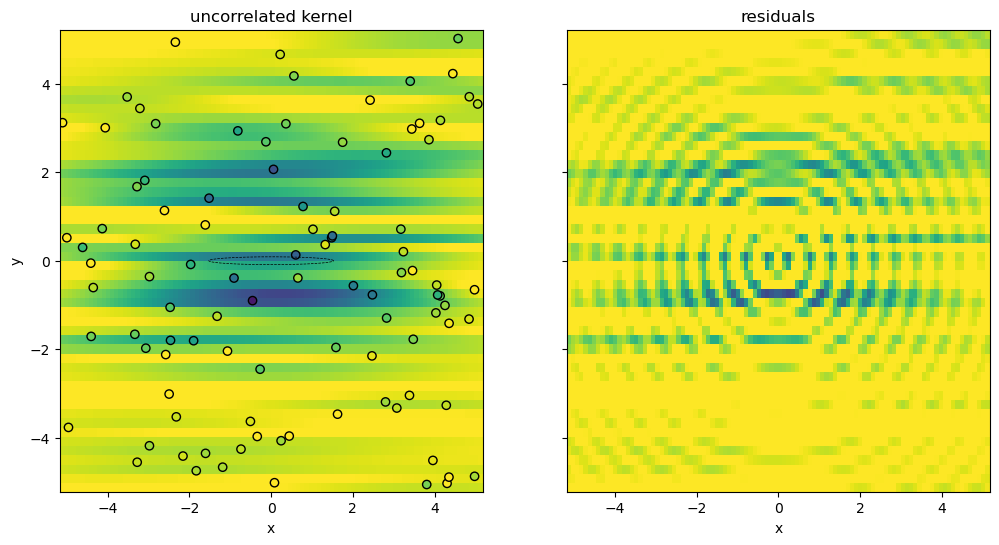

In [2]:
#drop-wave function using tinygp
import jax
import numpy as np
import jax.numpy as jnp
from tinygp import kernels
import numpy as np
import matplotlib.pyplot as plt
import jaxopt
from tinygp import GaussianProcess, kernels, transforms

jax.config.update("jax_enable_x64", True)

ndim = 3
X = np.random.default_rng(1).normal(size=(10, ndim))

# This kernel is equivalent...
scale = 1.5
kernel1 = kernels.Matern32(scale)

# ... to manually scaling the input coordinates
kernel0 = kernels.Matern32()
np.testing.assert_allclose(kernel0(X / scale, X / scale), kernel1(X, X))

#Drop-wave functin description
random = np.random.default_rng(48392)
X = random.uniform(-5.12, 5.12, (100, 2))
yerr = 0.1
y = -(1+np.cos(12*np.sqrt(X[:, 0]**2+X[:, 1]**2)))/(0.5*(X[:, 0]**2+X[:, 1]**2)+2) + yerr * random.normal(
    size=len(X))

# For plotting predictions on a grid
x_grid, y_grid = np.linspace(-5.12, 5.12, 100), np.linspace(-5.12, 5.12, 50)
x_, y_ = np.meshgrid(x_grid, y_grid)
y_true = -(1+np.cos(12*np.sqrt(x_**2+y_**2)))/(0.5*(x_**2+y_**2)+2)
X_pred = np.vstack((x_.flatten(), y_.flatten())).T

# For plotting covariance ellipses
theta = np.linspace(0, 2 * np.pi, 500)[None, :]
ellipse = 0.5 * np.concatenate((np.cos(theta), np.sin(theta)), axis=0)

plt.figure(figsize=(6, 6))
plt.pcolor(x_grid, y_grid, y_true, vmin=y_true.min(), vmax=y_true.max())
plt.scatter(
    X[:, 0], X[:, 1], c=y, ec="black", vmin=y_true.min(), vmax=y_true.max()
)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("data")

#tranining with Gaussian process
def train_gp(nparams, build_gp_func):
    @jax.jit
    def loss(params):
        return -build_gp_func(params).log_probability(y)

    params = {
        "log_amp": np.float64(0.0),
        "log_scale": np.zeros(nparams),
    }
    solver = jaxopt.ScipyMinimize(fun=loss)
    soln = solver.run(params)
    return build_gp_func(soln.params)

#Building Kernel
def build_gp_uncorr(params):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.exp(-params["log_scale"]), kernels.ExpSquared()
    )
    return GaussianProcess(kernel, X, diag=yerr**2)

#plotting results
uncorr_gp = train_gp(2, build_gp_uncorr)

y_pred = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)
xy = ellipse / uncorr_gp.kernel.kernel2.scale[:, None]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
axes[0].plot(xy[0], xy[1], "--k", lw=0.5)
axes[0].pcolor(x_, y_, y_pred, vmin=y_true.min(), vmax=y_true.max())
axes[0].scatter(
    X[:, 0], X[:, 1], c=y, ec="black", vmin=y_true.min(), vmax=y_true.max()
)
axes[1].pcolor(x_, y_, y_pred - y_true, vmin=y_true.min(), vmax=y_true.max())
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("uncorrelated kernel")
axes[1].set_xlabel("x")
_ = axes[1].set_title("residuals")

Predicted y value: -0.9683475281309216
Actual y value: -0.9362016440869844
10000


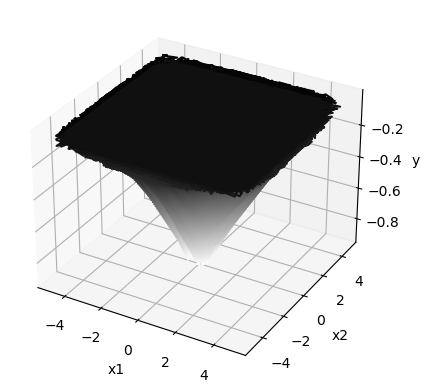

In [24]:
#drop-wave function using tinygp
import jax
import numpy as np
import jax.numpy as jnp
from tinygp import kernels
import numpy as np
import matplotlib.pyplot as plt
import jaxopt
from tinygp import GaussianProcess, kernels, transforms

jax.config.update("jax_enable_x64", True)

#Drop-wave functin description
random = np.random.default_rng(48393)
X = random.uniform(-5.12, 5.12, (100, 2))
yerr = 0.01
y = -(1+np.cos(12*np.sqrt(X[:, 0]**2+X[:, 1]**2)))/(0.5*(X[:, 0]**2+X[:, 1]**2)+2) + yerr * random.normal(
    size=len(X))

#Plotting drop-wave function
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
X1,X2 = np.meshgrid(X[:,0], X[:,1])
y_true = -(1+np.cos(12*np.sqrt(X1**2+X2**2)))/(0.5*(X1**2+X2**2)+2)
X_pred = np.vstack((X1.flatten(), X2.flatten())).T

ax.contour3D(X1, X2, y_true, 50, cmap='binary')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');

#Training data
def train_gp(nparams, build_gp_func):
    @jax.jit
    def loss(params):
        return -build_gp_func(params).log_probability(y)

    params = {
        "log_amp": np.float64(0.0),
        "log_scale": np.zeros(nparams),
    }
    solver = jaxopt.ScipyMinimize(fun=loss)
    soln = solver.run(params)
    return build_gp_func(soln.params)

#Kernel = Exponential squared, uncorrelated 
def build_gp_uncorr(params):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.exp(-params["log_scale"]), kernels.ExpSquared()
    )
    return GaussianProcess(kernel, X, diag=yerr**2)

uncorr_gp = train_gp(2, build_gp_uncorr)

y_pred = uncorr_gp.condition(y, X_pred).gp.loc.reshape(y_true.shape)

print(f"Predicted y value: {y_pred.min()}")

print(f"Actual y value: {y_true.min()}")

Initial negative log likelihood: 392.94231185701994
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray(3.3025811, dtype=float64), 'log_amps': DeviceArray([-56.37950097,   1.71669126,   4.11084749,  -2.13098285], dtype=float64), 'log_diag': DeviceArray(60.28268107, dtype=float64), 'log_gamma': DeviceArray(12.52278878, dtype=float64), 'log_period': DeviceArray(2339.70173767, dtype=float64), 'log_scales': DeviceArray([117.65693454,  -3.10865356, -27.13290445,  -4.04980878], dtype=float64), 'mean': DeviceArray(-0.15787706, dtype=float64)}
Final negative log likelihood: 296.5983219266162


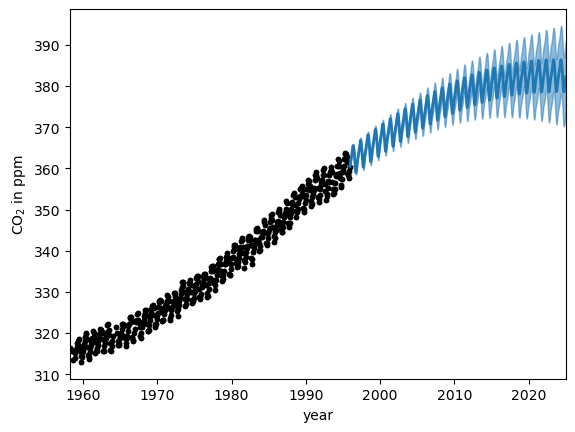

In [18]:
#https://github.com/dfm/tinygp/blob/main/docs/tutorials/quickstart.ipynb
#tiny gp tutorial on solving optimization problems

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

import jax
import jax.numpy as jnp

from tinygp import kernels, GaussianProcess


jax.config.update("jax_enable_x64", True)


def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    amps = jnp.exp(theta["log_amps"])
    scales = jnp.exp(theta["log_scales"])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = amps[0] * kernels.ExpSquared(scales[0])
    k2 = (
        amps[1]
        * kernels.ExpSquared(scales[1])
        * kernels.ExpSineSquared(
            scale=jnp.exp(theta["log_period"]),
            gamma=jnp.exp(theta["log_gamma"]),
        )
    )
    k3 = amps[2] * kernels.RationalQuadratic(
        alpha=jnp.exp(theta["log_alpha"]), scale=scales[2]
    )
    k4 = amps[3] * kernels.ExpSquared(scales[3])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"]), mean=theta["mean"]
    )


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "mean": np.float64(340.0),
    "log_diag": np.log(0.19),
    "log_amps": np.log([66.0, 2.4, 0.66, 0.18]),
    "log_scales": np.log([67.0, 90.0, 0.78, 1.6]),
    "log_period": np.float64(0.0),
    "log_gamma": np.log(4.3),
    "log_alpha": np.log(1.2),
}

# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

import jaxopt

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

x = np.linspace(max(t), 2025, 2000)
gp = build_gp(soln.params, t)
cond_gp = gp.condition(y, x).gp
mu, var = cond_gp.loc, cond_gp.variance

plt.plot(t, y, ".k")
plt.fill_between(
    x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
)
plt.plot(x, mu, color="C0", lw=2)

plt.xlim(t.min(), 2025)
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

10000
